### Exercise 3.3 PCA and Linear Regression (4 points)

Principal Component Regression (PCR) is a method used in statistical analysis, similar to traditional linear regression, model the relationship between a target and the predictor variables.

PCR differs from standard linear regression in that it uses principal components as the predictors rather than the original variables.

PCR's process involves:
<ol>
<li>Implementing Principal Component Analysis (PCA) to transform predictor variables into principal components. Selecting the top k principal components, which account for the majority of the data variance (where k is less than number of original variables). The choice of k is based on cross-validation results. </li>

<li>Constructing a linear regression model using these k principal components.</li>

<li>The reasoning behind PCR is that these fewer principal components capture the majority of the data's variability, and are assumed to be more representative of the connection with the dependent variable. Hence, PCR focuses on a smaller, more significant subset of principal components rather than utilizing all original variables for regression analysis.</li>
</ol>

Write your code in the respective cells. Of course, you can add additional cells or change their order, but please don't significantly change the structure of the notebook. You must use PyTorch tensors to perform all the calculations.  
For each question that requires written answer, please write it in a markdown cell.

#### Getting the data ready

In [1]:
import pandas as pd
from sklearn.preprocessing import scale 
from sklearn.model_selection import train_test_split

Load the data

In [2]:
df = pd.read_csv('./data.csv', sep=',')
df.head()

,Unnamed: 0,x0,x1,x2,x3,x4,x5,x6,x7,x8,...,x35,x36,x37,x38,x39,x40,x41,x42,x43,y
0,0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,...,4.15,3.52,3.53,1.36,1.24,1.91,9.81,10.16,19.37,5
1,1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,...,3.84,3.21,3.22,1.60,1.36,2.15,10.21,10.56,20.17,5
2,2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,...,3.90,3.27,3.28,1.54,1.33,2.09,10.21,10.56,20.17,5
3,3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,...,3.80,3.17,3.18,1.40,1.26,1.95,10.21,10.56,20.17,6
4,4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,...,4.15,3.52,3.53,1.36,1.24,1.91,9.81,10.16,19.37,5


In [3]:
X = df.values[:,:-1]
y = df.values[:,-1]
print(X.shape, y.shape)

(1599, 45) (1599,)


Split into train and test

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape

(1279, 45)

Standardize Features

In [5]:
X_train_scaled, X_test_scaled = scale(X_train), scale(X_test)

#### 3.3.1 Perform PCA on the input data and visualize the data (2 point)

In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [7]:
X_train_scaled_tensor = torch.tensor(X_train_scaled)
X_train_scaled_tensor.shape

torch.Size([1279, 45])

Calculate covariance matrix of the input data. Hint: You can use torch.matmul for matrix multiplication.

In [8]:
cov = torch.matmul(torch.transpose(X_train_scaled_tensor, 0, 1), X_train_scaled_tensor) * (1/(X_train_scaled_tensor.shape[1] - 1))
cov.shape

torch.Size([45, 45])

Perform eigendecomposion of the covariance matrix

In [9]:
covL, covV = torch.linalg.eigh(cov)
covV.shape

torch.Size([45, 45])

Extract the first two principal components of the data, i.e. reduce the dimensionality of the dataset to 2. Plot the result. Different numbers must be represented as different colors on the scatter plot. You can use a randomly sampled portion of the data so that the plot doesn't get cluttered.

In [10]:
covL_sorted_indices = torch.argsort(covL, descending=True)
covV_sorted = covV[:, covL_sorted_indices]

In [11]:
D2 = covV_sorted[:,:2]
D2T = torch.transpose(D2, 0, 1)
print(D2.shape, D2T.shape)

torch.Size([45, 2]) torch.Size([2, 45])


torch.Size([1279, 2])


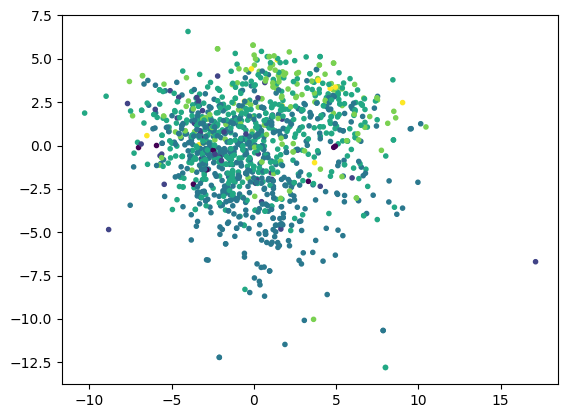

In [12]:
c = torch.matmul(X_train_scaled_tensor, D2)
print(c.shape)
plt.scatter(c[:, 0], c[:, 1], marker='.', c=y_train)
plt.show()

#### [Extra] compare result with sklearn PCA

In [13]:
from sklearn.decomposition import PCA

def sort_eigen_desc(l: torch.Tensor, v: torch.Tensor) -> (torch.Tensor, torch.Tensor):
    l_sorted, l_sorted_indices = torch.sort(l, descending=True)
    return l_sorted, v[:, l_sorted_indices]

def get_pca(x, l) -> (float, float):
    cov = torch.matmul(torch.transpose(x, 0, 1), x) * (1/(x.shape[1] - 1))
    covl, covv = sort_eigen_desc(*torch.linalg.eigh(cov))

    d = covv[:,:l]
    dt = torch.transpose(d, 0, 1)

    c = torch.matmul(x, d)
    xhat = torch.matmul(c, dt)

    return get_error(xhat.numpy(), x.numpy()), get_cum_var(covl[:l].numpy())
    
def get_error(x: np.ndarray, y: np.ndarray):
    return np.linalg.norm(x - y, 'fro') ** 2

def get_cum_var(vs: np.ndarray):
    return np.sum(vs)

def get_pca_skl(x, l) -> (float, float):
    pca = PCA(n_components=l)
    c = pca.fit_transform(x)
    xhat = pca.inverse_transform(c)
    return get_error(xhat, x.numpy()), get_cum_var(pca.explained_variance_)


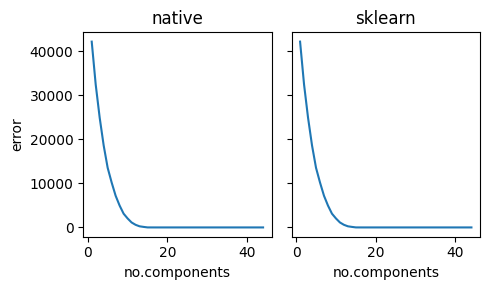

In [14]:
# I compared the loss vs no. components result (native) with the sklearn one
no_components = range(X_train_scaled_tensor.shape[1] - 1, 0, -1)
native_results = np.array([get_pca(X_train_scaled_tensor, l) for l in no_components])
sklearn_results = np.array([get_pca_skl(X_train_scaled_tensor, l) for l in no_components])

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 3), sharey=True)
axes[0].plot(no_components, native_results[:, 0])
axes[0].set_title('native')
axes[0].set_ylabel('error')
axes[0].set_xlabel('no.components')

axes[1].plot(no_components, sklearn_results[:, 0])
axes[1].set_title('sklearn')
axes[1].set_xlabel('no.components')

# which is the same
fig.tight_layout()

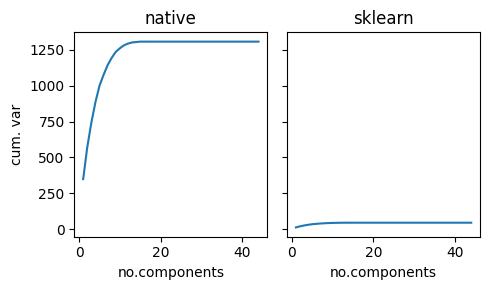

In [15]:
# now compare the explained_variance_ratios
fig2, axes2 = plt.subplots(nrows=1, ncols=2, figsize=(5, 3), sharey=True)
axes2[0].plot(no_components, native_results[:, 1])
axes2[0].set_title('native')
axes2[0].set_ylabel('cum. var')
axes2[0].set_xlabel('no.components')

axes2[1].plot(no_components, sklearn_results[:, 1])
axes2[1].set_title('sklearn')
axes2[1].set_xlabel('no.components')

# which is the same
fig2.tight_layout()

Plot the graph of cumulative explained variance vs number of components.

#### 3.3.2 Train Regression models (2 points)

Given training dataset $D = \{x_i,y_i\}_{i=1}^n$ where $x_i \in \mathbb{R}^d, y_i \in \mathbb{R}$ the ordinary linear least square regression minimizes the cost function 
$f(x,y;w) = \frac{1}{n} \sum_{i=1}^n (y_i - \langle w, x_i \rangle - b )^2$  
But sometimes this leads to overfitting or ill posed problems hence we add a regularizational term to the objective function  
$f(x,y;w) = \frac{1}{n} \sum_{i=1}^n (y_i - \langle w, x_i \rangle - b )^2 + \lambda \sum_{i=1}^d w_i^2$  
In practice we artificially add another dimension of 1's to $X$ to absorb the offset term b such that the objective function in matrix vector form becomes  
$f(x,y;w) = \frac{1}{n} \Vert Y - Xw \Vert^2 + \lambda \Vert w \Vert^2 $ where
    $
        X = \begin{bmatrix}
    X_{1,1} & \cdots & X_{1,d} & 1\\
    X_{2,1}  & \cdots & X_{2,d} & 1 \\
    \vdots & \vdots & \vdots & \vdots \\
    X_{n,1} & \cdots & X_{n,d} & 1
    \end{bmatrix}
    $
 and $w = \begin{bmatrix}w_1 & w_2 & ... & w_d & b \end{bmatrix}^T$. 

The closed form of $w^*$ which minimizes objective function $f(x,y;w) = \frac{1}{n} \Vert Y - Xw \Vert^2 + \lambda \Vert w \Vert^2 $ is $w^* = (X^TX + \lambda \mathbb{I})^{-1}X^TY$ . Your task is to programatically implement this closed form solution for ridge regression.

#### 3.2.2a (1 point)

Implement the fit() function in the ridge_regression class which takes three parameters X, Y and LAMBDA. The fit() function computes the minimizer $w^*$ for the regularized mean squared error objective function. Store the value of $w^*$ in self.w  

Implement the predict() function that takes a matrix X and returns the predictions of the model on X and since the bias term is absorbed in $w$, please do not forget to add another dimension of 1's to X as described earlier in both the fit() and predict functions

Assume that fit() is called before using predict(). 
**Use only basic matrix vector operations from numpy**

In [16]:
class ridge_regression:
    def __init__(self):
        self.w = None # self.w.shape = (d+1,)
    
    def fit(self, X, Y, LAMBDA = 0.3): 
        """
        args: X.shape = (n, d). We account for the bias parameter w_0 in the 
                design matrix X by artificially adding another dimension
                Y.shape = (n, 1)
        returns: None
        Note that you have to artificially add a dimension of 1 as defined earlier to account for the bias term
        """
        X = np.hstack((X, np.ones((X.shape[0], 1))))
        self.w = np.linalg.inv(X.T @ X + np.identity(X.shape[1])) @ X.T @ Y

    def predict(self, X):
        """
        Note that you have to artificially add a dimension of 1 as defined earlier to account for the bias term
        """
        X = np.hstack((X, np.ones((X.shape[0], 1))))
        return X @ self.w

##### 3.3.2b Run Baseline Regression Model (0.5 points)

To evaluate the performance of the PCR model, we need to have benchmark to compare with. For this train a regression model using the original variables as the Input.

Record the mean squared error for the evaluation

In [17]:
from sklearn.metrics import mean_squared_error

In [18]:
reg = ridge_regression()
reg.fit(X_train, y_train)
mean_squared_error(y_test, reg.predict(X_test))

0.3901121997255509

##### 3.3.2c Classification using principal components (0.5 points)

For $K = 1...11$ select top K principal components. Project the X_train_scaled data into a subspace using these $K$ princiapl components. Train a Regression model using this projected dataset. Repeat the projection operation on the X_test_scaled data and predict the output. Evaluate the model's performance using mean squared error.

Plot a graph of model's performance against its $K$ value. Also Plot the baseline MSE from the previous question in the same graph for comparison.

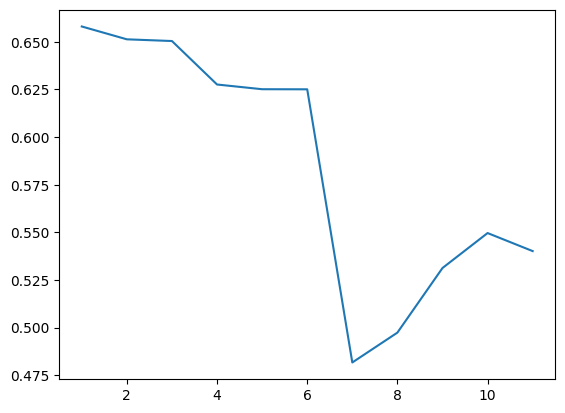

In [25]:
def sort_eigen_np_desc(l: np.ndarray, v: np.ndarray) -> (np.ndarray, np.ndarray):
    indices = np.argsort(l)[::-1]
    return l[indices], v[:, indices]

class NativePCA:
    def __init__(self, l):
        self.l = l
        self.d = None
    
    def fit(self, x):
        cov = x.T @ x * (1/(x.shape[1] - 1))
        covl, covv = sort_eigen_np_desc(*np.linalg.eigh(cov))
        self.d = covv[:,:self.l]

    def encode(self, x):
        return x @ self.d

def get_mse(k):
    pca_train = NativePCA(k)
    pca_train.fit(X_train)
    c_train = pca_train.encode(X_train)
    reg = ridge_regression()
    reg.fit(c_train, y_train)

    pca_test = NativePCA(k)
    pca_test.fit(X_test)
    c_test = pca_test.encode(X_test)
    y_pred = reg.predict(c_test)
    return mean_squared_error(y_test, y_pred)

ks = range(1, 12)
mses = [get_mse(k) for k in ks]
plt.plot(ks, mses)
plt.show()

How does the performance change with the different $K$ values 